Import

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torchvision import transforms
from PIL import Image
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

CONFIGURATION GLOBALE

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"{'='*70}")
print(f"Device utilisé: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
print(f"{'='*70}\n")

# Hyperparamètres
IMG_SIZE = 64
BATCH_SIZE = 16
EPOCHS = 8
NUM_CLASSES = 2
SEED = 42

# Configuration ViT
PATCH_SIZE = 8
D_MODEL = 64
NUM_HEADS = 4
MLP_HIDDEN = 128
DROPOUT = 0.1

torch.manual_seed(SEED)
np.random.seed(SEED)

Device utilisé: cuda
GPU: Tesla T4



DATASET

In [9]:
class SkinDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = self.df.iloc[idx]['image_id'] + ".jpg"
        # Si label == "mel" -> classe 0 (Malade), sinon -> classe 1 (Saine)
        label = 0 if self.df.iloc[idx]['label'] == "mel" else 1

        img_path = os.path.join(self.img_dir, img_name)
        img = Image.open(img_path).convert("RGB")
        
        if self.transform:
            img = self.transform(img)

        return img, label

TRANSFORMATIONS

In [10]:
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

## ========== SECTION 5: CHARGEMENT DES DONNÉES ==========
print("Chargement des données...")
# Charger le CSV avec le bon séparateur
df = pd.read_csv("/kaggle/input/ham-data-label/HAM500_metadata.csv", sep=';')

# Afficher les premières lignes pour vérifier
print(f"Colonnes du CSV: {df.columns.tolist()}")
print(f"\nPremières lignes:\n{df.head()}")
print(f"\nTotal d'images: {len(df)}")
print(f"Distribution des classes:\n{df['label'].value_counts()}")

# Vérifier les valeurs uniques de label
print(f"\nLabels uniques: {df['label'].unique()}")
print(f"\nMapping: 'mel' -> 0 (Malade), autres -> 1 (Saine)\n")

# Split 80/20 avec seed fixée
train_df, val_df = train_test_split(df, test_size=0.2, random_state=SEED, stratify=df['label'])

img_dir = "/kaggle/input/hamdataset/HAM500_images"
train_ds = SkinDataset(train_df, img_dir, transform)
val_ds = SkinDataset(val_df, img_dir, transform)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train samples: {len(train_ds)}")
print(f"Validation samples: {len(val_ds)}\n")

Chargement des données...
Colonnes du CSV: ['lesion_id', 'image_id', 'label']

Premières lignes:
     lesion_id      image_id label
0  HAM_0000550  ISIC_0024306    nv
1  HAM_0003577  ISIC_0024307    nv
2  HAM_0001477  ISIC_0024308    nv
3  HAM_0000484  ISIC_0024309    nv
4  HAM_0003350  ISIC_0024310   mel

Total d'images: 500
Distribution des classes:
label
nv       332
bkl       57
mel       43
bcc       34
akiec     21
vasc       8
df         5
Name: count, dtype: int64

Labels uniques: ['nv' 'mel' 'bkl' 'df' 'akiec' 'bcc' 'vasc']

Mapping: 'mel' -> 0 (Malade), autres -> 1 (Saine)

Train samples: 400
Validation samples: 100



TÊTE VGG16 (COMMUNE À TOUS LES MODÈLES)

In [11]:
class VGG16Head(nn.Module):
    """Tête de classification VGG16 - identique pour tous les modèles"""
    def __init__(self, input_dim=512, num_classes=2):
        super(VGG16Head, self).__init__()
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes)
        )
    
    def forward(self, x):
        return self.classifier(x)

CNN PERSONNALISÉ

In [12]:
class CustomCNN(nn.Module):
    """CNN personnalisé from scratch selon architecture imposée"""
    def __init__(self, num_classes=2):
        super(CustomCNN, self).__init__()
        
        # Bloc 1
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Bloc 2
        self.block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Bloc 3
        self.block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Bloc 4
        self.block4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Bloc 5 (projection vers 512)
        self.block5 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=1, stride=1, padding=0),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1))  # Global Average Pooling
        )
        
        # Tête VGG16
        self.head = VGG16Head(512, num_classes)
    
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)  # Output: (B, 512, 1, 1)
        x = self.head(x)
        return x

VGG16 FROM SCRATCH

In [13]:
class VGG16(nn.Module):
    """VGG16 from scratch (sans transfer learning)"""
    def __init__(self, num_classes=2):
        super(VGG16, self).__init__()
        
        # Bloc 1
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Bloc 2
        self.block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Bloc 3
        self.block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Bloc 4
        self.block4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Bloc 5
        self.block5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Adapter pour 64x64: après 5 MaxPool, on a 2x2
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Tête VGG16
        self.head = VGG16Head(512, num_classes)
    
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.adaptive_pool(x)  # (B, 512, 1, 1)
        x = self.head(x)
        return x

COMPOSANTS ViT

In [14]:
class PatchEmbedding(nn.Module):
    """Découpe l'image en patches et les projette"""
    def __init__(self, img_size=64, patch_size=8, in_channels=3, d_model=64):
        super().__init__()
        self.num_patches = (img_size // patch_size) ** 2
        self.projection = nn.Conv2d(in_channels, d_model, 
                                    kernel_size=patch_size, 
                                    stride=patch_size)
        
    def forward(self, x):
        x = self.projection(x)  # (B, d_model, H/P, W/P)
        x = x.flatten(2)  # (B, d_model, num_patches)
        x = x.transpose(1, 2)  # (B, num_patches, d_model)
        return x

class MultiHeadAttention(nn.Module):
    """Multi-Head Self-Attention"""
    def __init__(self, d_model=64, num_heads=4, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        
        self.qkv = nn.Linear(d_model, d_model * 3)
        self.out_proj = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        B, N, C = x.shape
        
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        
        attn = (q @ k.transpose(-2, -1)) / (self.head_dim ** 0.5)
        attn = F.softmax(attn, dim=-1)
        attn = self.dropout(attn)
        
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.out_proj(x)
        x = self.dropout(x)
        
        return x

class MLP(nn.Module):
    """Feedforward MLP"""
    def __init__(self, d_model=64, hidden_dim=128, dropout=0.1):
        super().__init__()
        self.fc1 = nn.Linear(d_model, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return x

class TransformerEncoderBlock(nn.Module):
    """Bloc Transformer Encoder"""
    def __init__(self, d_model=64, num_heads=4, mlp_hidden=128, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(d_model)
        self.attn = MultiHeadAttention(d_model, num_heads, dropout)
        self.norm2 = nn.LayerNorm(d_model)
        self.mlp = MLP(d_model, mlp_hidden, dropout)
        
    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

ViT-1 (1 BLOC)

In [15]:
class ViT_1(nn.Module):
    """Vision Transformer avec 1 bloc encodeur"""
    def __init__(self, img_size=64, patch_size=8, in_channels=3, 
                 d_model=64, num_heads=4, mlp_hidden=128, 
                 dropout=0.1, num_classes=2):
        super().__init__()
        
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, d_model)
        num_patches = self.patch_embed.num_patches
        
        self.cls_token = nn.Parameter(torch.zeros(1, 1, d_model))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, d_model))
        self.dropout = nn.Dropout(dropout)
        
        # 1 bloc encodeur
        self.encoder = TransformerEncoderBlock(d_model, num_heads, mlp_hidden, dropout)
        
        self.norm = nn.LayerNorm(d_model)
        self.projection = nn.Linear(d_model, 512)
        self.head = VGG16Head(512, num_classes)
        
    def forward(self, x):
        B = x.shape[0]
        
        x = self.patch_embed(x)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat([cls_tokens, x], dim=1)
        x = x + self.pos_embed
        x = self.dropout(x)
        
        x = self.encoder(x)
        x = self.norm(x)
        x = x[:, 0]  # class token
        x = self.projection(x)
        x = self.head(x)
        
        return x

ViT-2 (2 BLOCS)

In [16]:
class ViT_2(nn.Module):
    """Vision Transformer avec 2 blocs encodeurs"""
    def __init__(self, img_size=64, patch_size=8, in_channels=3, 
                 d_model=64, num_heads=4, mlp_hidden=128, 
                 dropout=0.1, num_classes=2):
        super().__init__()
        
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, d_model)
        num_patches = self.patch_embed.num_patches
        
        self.cls_token = nn.Parameter(torch.zeros(1, 1, d_model))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, d_model))
        self.dropout = nn.Dropout(dropout)
        
        # 2 blocs encodeurs
        self.encoder1 = TransformerEncoderBlock(d_model, num_heads, mlp_hidden, dropout)
        self.encoder2 = TransformerEncoderBlock(d_model, num_heads, mlp_hidden, dropout)
        
        self.norm = nn.LayerNorm(d_model)
        self.projection = nn.Linear(d_model, 512)
        self.head = VGG16Head(512, num_classes)
        
    def forward(self, x):
        B = x.shape[0]
        
        x = self.patch_embed(x)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat([cls_tokens, x], dim=1)
        x = x + self.pos_embed
        x = self.dropout(x)
        
        x = self.encoder1(x)
        x = self.encoder2(x)
        
        x = self.norm(x)
        x = x[:, 0]  # class token
        x = self.projection(x)
        x = self.head(x)
        
        return x

FONCTIONS D'ENTRAÎNEMENT

In [17]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    epoch_loss = running_loss / len(loader)
    accuracy = accuracy_score(all_labels, all_preds)
    
    # Pour le calcul de precision, recall, f1 : classe Malade = 0
    # pos_label=0 pour que les métriques se concentrent sur la classe Malade
    precision = precision_score(all_labels, all_preds, pos_label=0, zero_division=0)
    recall = recall_score(all_labels, all_preds, pos_label=0, zero_division=0)
    f1 = f1_score(all_labels, all_preds, pos_label=0, zero_division=0)
    cm = confusion_matrix(all_labels, all_preds)
    
    return epoch_loss, accuracy, precision, recall, f1, cm, all_preds, all_labels

FONCTION D'ENTRAÎNEMENT GÉNÉRIQUE

In [18]:
def train_model(model, model_name, train_loader, val_loader, epochs=8, lr=0.001):
    print(f"\n{'='*70}")
    print(f"ENTRAÎNEMENT {model_name}")
    print(f"{'='*70}")
    
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    
    best_val_acc = 0.0
    
    for epoch in range(epochs):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc, val_prec, val_rec, val_f1, cm, _, _ = validate(
            model, val_loader, criterion, device)
        
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc * 100)
        
        print(f"Epoch {epoch+1}/{epochs} - "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}%")
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), f'{model_name.lower()}_best.pth')
    
    # Charger le meilleur modèle
    model.load_state_dict(torch.load(f'{model_name.lower()}_best.pth'))
    
    # Évaluation finale
    _, final_acc, final_prec, final_rec, final_f1, final_cm, _, _ = validate(
        model, val_loader, criterion, device)
    
    print(f"\n{'='*70}")
    print(f"MÉTRIQUES FINALES {model_name}")
    print(f"{'='*70}")
    print(f"Accuracy:  {final_acc:.4f}")
    print(f"Precision: {final_prec:.4f}")
    print(f"Recall:    {final_rec:.4f} (classe Malade)")
    print(f"F1-Score:  {final_f1:.4f}")
    print(f"\nMatrice de Confusion:")
    print(final_cm)
    print(f"{'='*70}")
    
    # Sauvegarder le modèle final
    torch.save({
        'model_state_dict': model.state_dict(),
        'train_losses': train_losses,
        'train_accs': train_accs,
        'val_losses': val_losses,
        'val_accs': val_accs,
        'final_metrics': {
            'accuracy': final_acc,
            'precision': final_prec,
            'recall': final_rec,
            'f1_score': final_f1,
            'confusion_matrix': final_cm
        }
    }, f'{model_name.lower()}_final.pth')
    
    return {
        'model': model,
        'train_losses': train_losses,
        'train_accs': train_accs,
        'val_losses': val_losses,
        'val_accs': val_accs,
        'metrics': {
            'accuracy': final_acc,
            'precision': final_prec,
            'recall': final_rec,
            'f1_score': final_f1,
            'confusion_matrix': final_cm
        }
    }

ENTRAÎNEMENT DE TOUS LES MODÈLES

In [19]:
# 1. CNN Personnalisé
cnn_model = CustomCNN(num_classes=NUM_CLASSES)
cnn_results = train_model(cnn_model, "CNN", train_loader, val_loader, EPOCHS, 0.001)

# 2. VGG16 from scratch
vgg16_model = VGG16(num_classes=NUM_CLASSES)
vgg16_results = train_model(vgg16_model, "VGG16", train_loader, val_loader, EPOCHS, 0.001)

# 3. ViT-1 (1 bloc)
vit1_model = ViT_1(img_size=IMG_SIZE, patch_size=PATCH_SIZE, d_model=D_MODEL,
                   num_heads=NUM_HEADS, mlp_hidden=MLP_HIDDEN, dropout=DROPOUT,
                   num_classes=NUM_CLASSES)
vit1_results = train_model(vit1_model, "ViT-1", train_loader, val_loader, EPOCHS, 0.001)

# 4. ViT-2 (2 blocs)
vit2_model = ViT_2(img_size=IMG_SIZE, patch_size=PATCH_SIZE, d_model=D_MODEL,
                   num_heads=NUM_HEADS, mlp_hidden=MLP_HIDDEN, dropout=DROPOUT,
                   num_classes=NUM_CLASSES)
vit2_results = train_model(vit2_model, "ViT-2", train_loader, val_loader, EPOCHS, 0.001)

## ========== SECTION 15: TABLEAU COMPARATIF ==========
print(f"\n{'='*70}")
print("TABLEAU COMPARATIF DES MÉTRIQUES")
print(f"{'='*70}")
print(f"{'Modèle':<15} {'Accuracy':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
print(f"{'-'*70}")

models_results = {
    'CNN': cnn_results,
    'VGG16': vgg16_results,
    'ViT-1': vit1_results,
    'ViT-2': vit2_results
}

for name, results in models_results.items():
    m = results['metrics']
    print(f"{name:<15} {m['accuracy']:<12.4f} {m['precision']:<12.4f} {m['recall']:<12.4f} {m['f1_score']:<12.4f}")

print(f"{'='*70}\n")


ENTRAÎNEMENT CNN
Epoch 1/8 - Train Loss: 0.3558, Train Acc: 89.75% | Val Loss: 0.2872, Val Acc: 91.00%
Epoch 2/8 - Train Loss: 0.2995, Train Acc: 91.50% | Val Loss: 0.2927, Val Acc: 91.00%
Epoch 3/8 - Train Loss: 0.3115, Train Acc: 91.50% | Val Loss: 0.2824, Val Acc: 91.00%
Epoch 4/8 - Train Loss: 0.3044, Train Acc: 91.50% | Val Loss: 0.2814, Val Acc: 91.00%
Epoch 5/8 - Train Loss: 0.2976, Train Acc: 91.50% | Val Loss: 0.3054, Val Acc: 91.00%
Epoch 6/8 - Train Loss: 0.3082, Train Acc: 91.50% | Val Loss: 0.2814, Val Acc: 91.00%
Epoch 7/8 - Train Loss: 0.3053, Train Acc: 91.50% | Val Loss: 0.2851, Val Acc: 91.00%
Epoch 8/8 - Train Loss: 0.2974, Train Acc: 91.50% | Val Loss: 0.2863, Val Acc: 91.00%

MÉTRIQUES FINALES CNN
Accuracy:  0.9100
Precision: 0.0000
Recall:    0.0000 (classe Malade)
F1-Score:  0.0000

Matrice de Confusion:
[[ 0  9]
 [ 0 91]]

ENTRAÎNEMENT VGG16
Epoch 1/8 - Train Loss: 0.6694, Train Acc: 89.75% | Val Loss: 0.2906, Val Acc: 91.00%
Epoch 2/8 - Train Loss: 0.3020, Tra

VISUALISATION DES COURBES

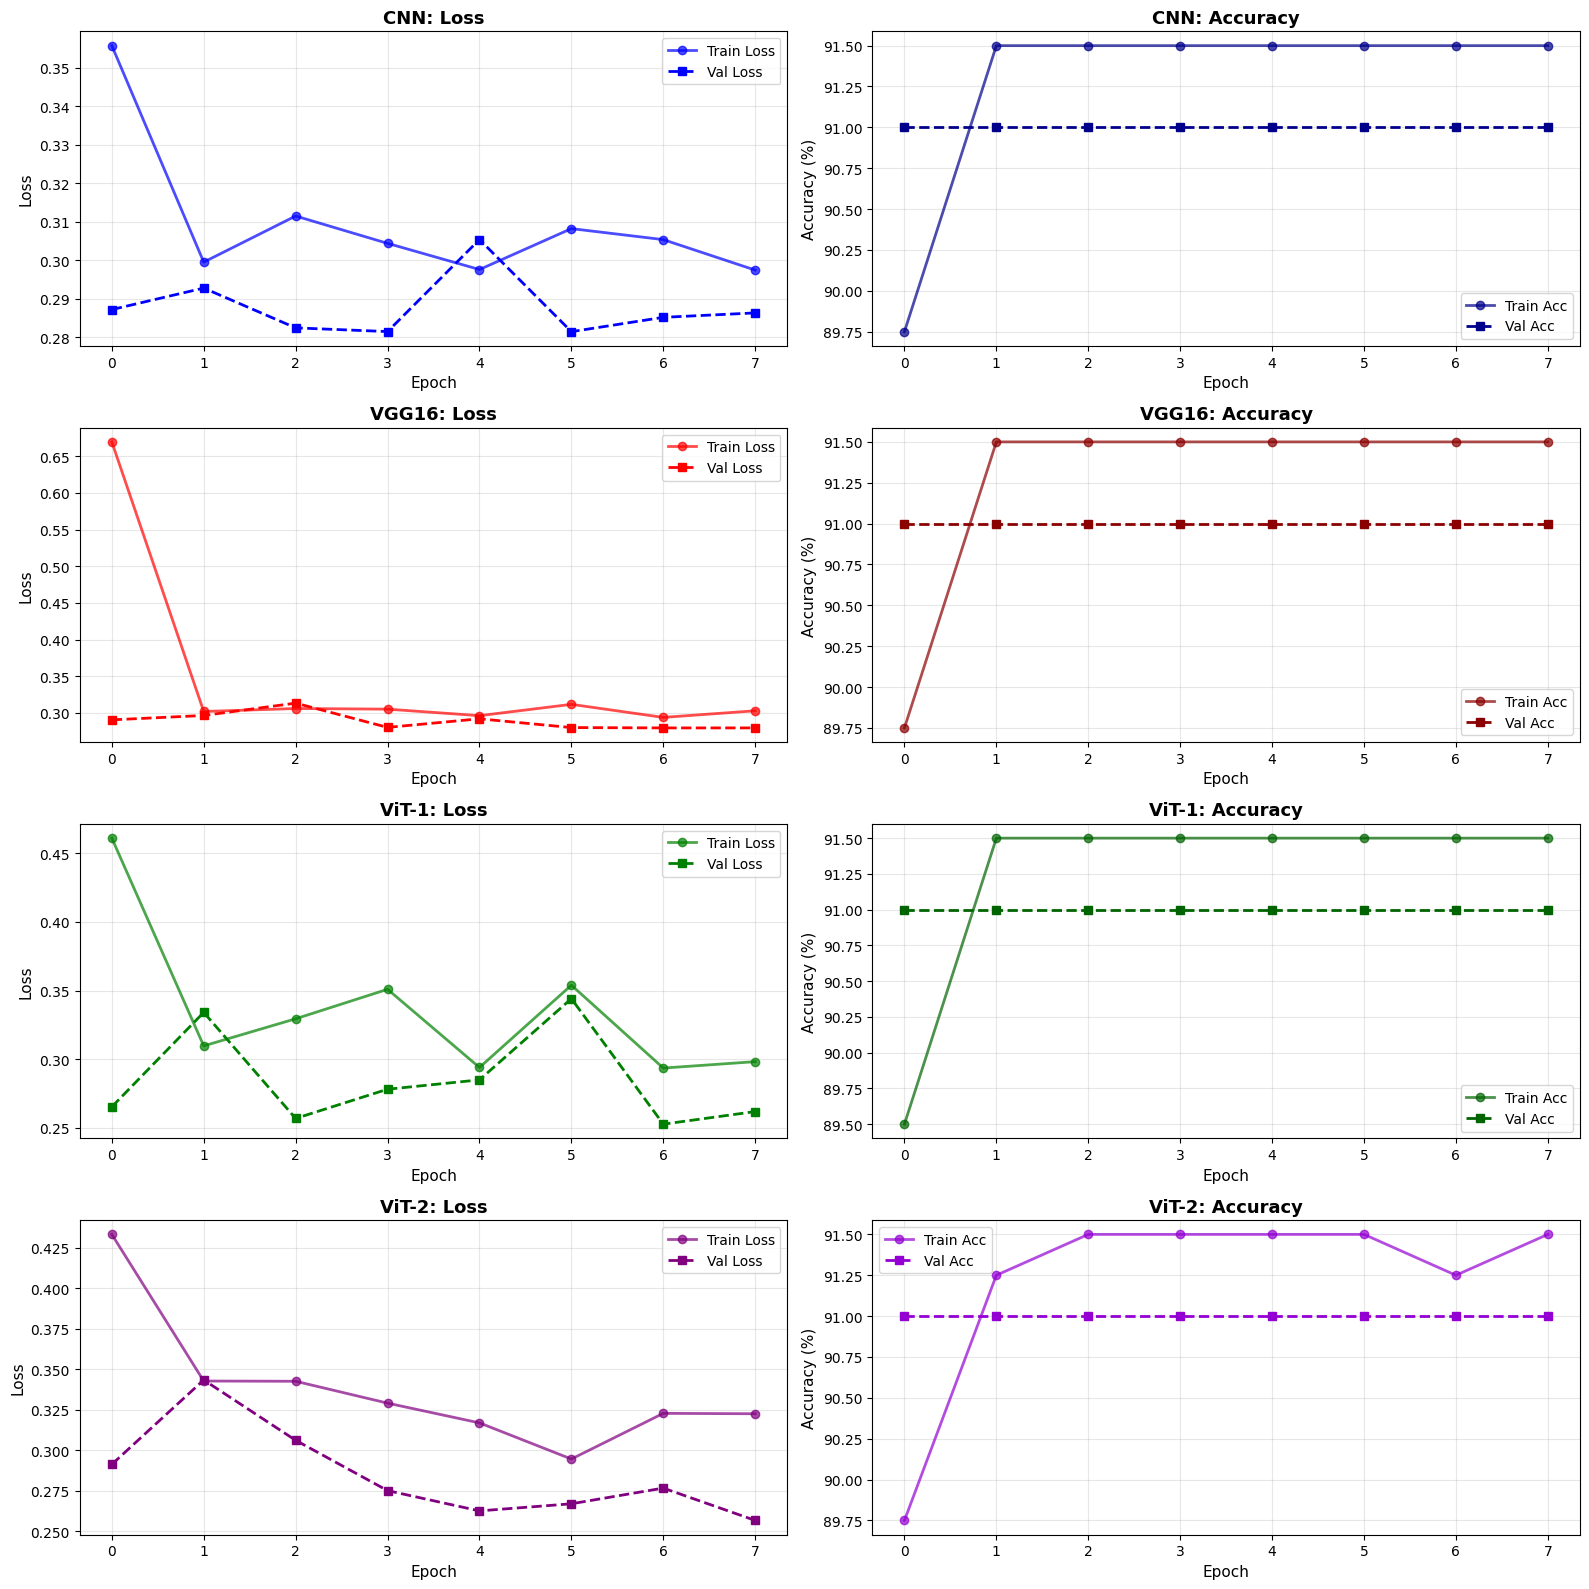

 ENTRAÎNEMENT TERMINÉ - Tous les modèles sont prêts pour l'ÉTAPE 2


In [20]:
fig, axes = plt.subplots(4, 2, figsize=(16, 16))

models_names = ['CNN', 'VGG16', 'ViT-1', 'ViT-2']
colors_loss = ['blue', 'red', 'green', 'purple']
colors_acc = ['darkblue', 'darkred', 'darkgreen', 'darkviolet']

for idx, (name, results) in enumerate(models_results.items()):
    # Loss
    axes[idx, 0].plot(results['train_losses'], label='Train Loss', 
                     marker='o', linewidth=2, color=colors_loss[idx], alpha=0.7)
    axes[idx, 0].plot(results['val_losses'], label='Val Loss', 
                     marker='s', linewidth=2, color=colors_loss[idx], linestyle='--')
    axes[idx, 0].set_xlabel('Epoch', fontsize=11)
    axes[idx, 0].set_ylabel('Loss', fontsize=11)
    axes[idx, 0].set_title(f'{name}: Loss', fontsize=13, fontweight='bold')
    axes[idx, 0].legend(fontsize=10)
    axes[idx, 0].grid(True, alpha=0.3)
    
    # Accuracy
    axes[idx, 1].plot(results['train_accs'], label='Train Acc', 
                     marker='o', linewidth=2, color=colors_acc[idx], alpha=0.7)
    axes[idx, 1].plot(results['val_accs'], label='Val Acc', 
                     marker='s', linewidth=2, color=colors_acc[idx], linestyle='--')
    axes[idx, 1].set_xlabel('Epoch', fontsize=11)
    axes[idx, 1].set_ylabel('Accuracy (%)', fontsize=11)
    axes[idx, 1].set_title(f'{name}: Accuracy', fontsize=13, fontweight='bold')
    axes[idx, 1].legend(fontsize=10)
    axes[idx, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('all_models_training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print(" ENTRAÎNEMENT TERMINÉ - Tous les modèles sont prêts pour l'ÉTAPE 2")

SAUVEGARDE DES RÉSULTATS


 Métriques sauvegardées: metriques_validation.csv


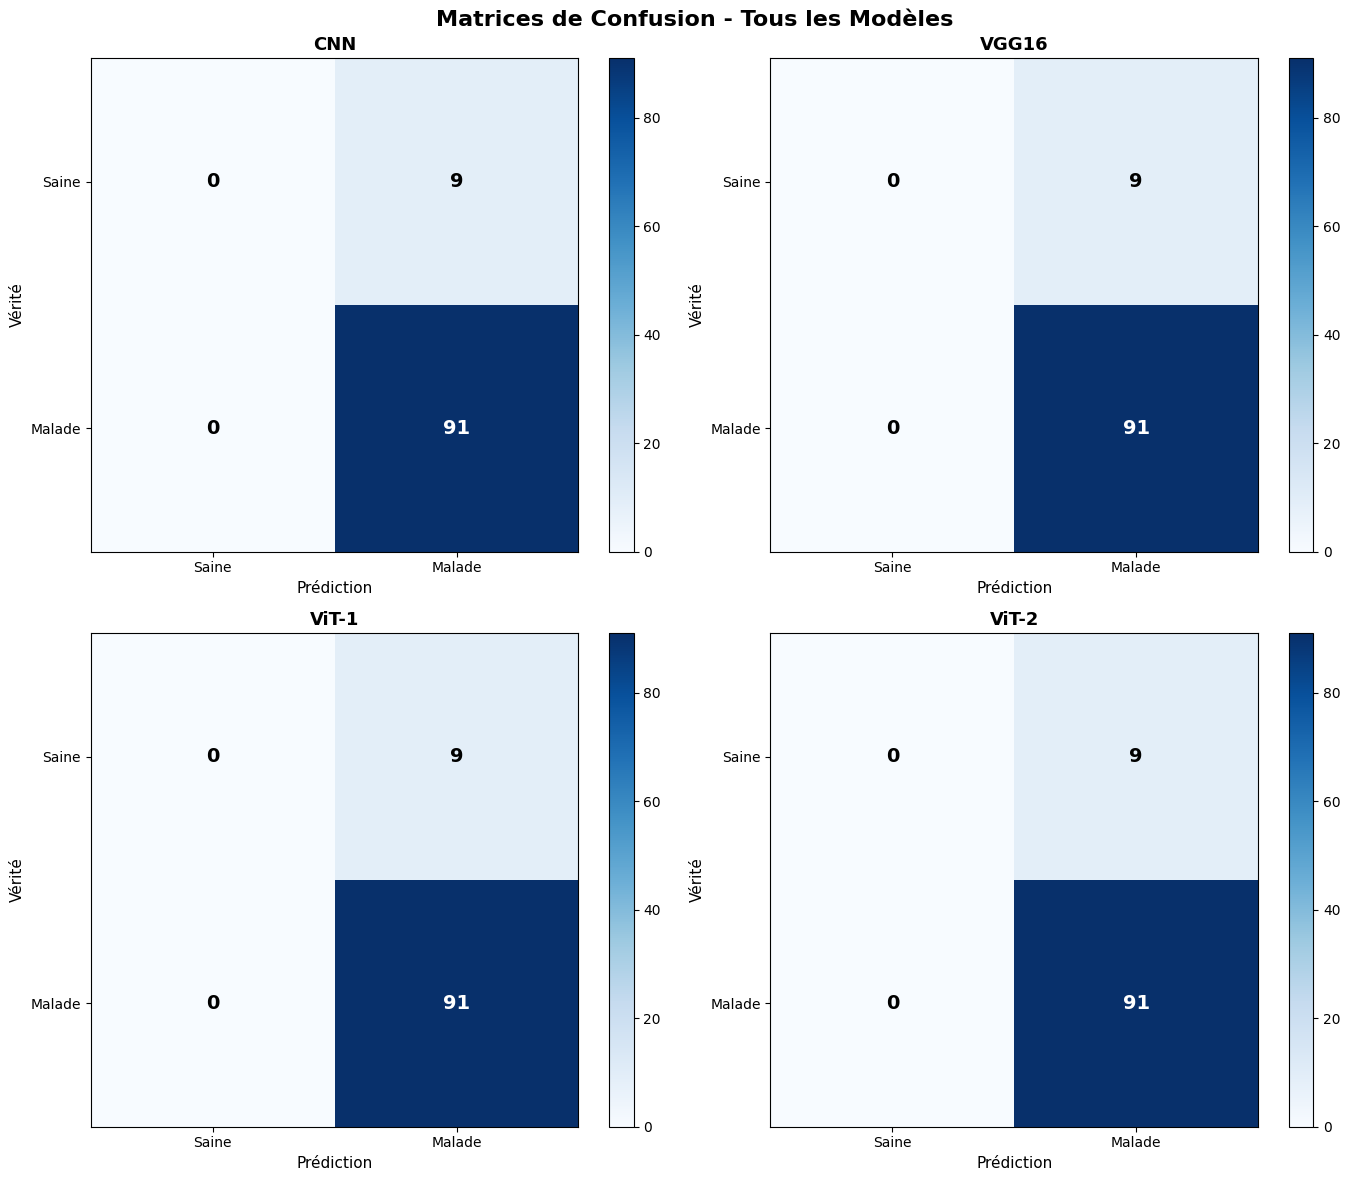

 Matrices de confusion sauvegardées: confusion_matrices.png


In [21]:
# Créer un DataFrame avec toutes les métriques
metrics_df = pd.DataFrame({
    'Modèle': ['CNN', 'VGG16', 'ViT-1', 'ViT-2'],
    'Accuracy': [m['metrics']['accuracy'] for m in models_results.values()],
    'Precision': [m['metrics']['precision'] for m in models_results.values()],
    'Recall': [m['metrics']['recall'] for m in models_results.values()],
    'F1-Score': [m['metrics']['f1_score'] for m in models_results.values()]
})

# Sauvegarder en CSV
metrics_df.to_csv('metriques_validation.csv', index=False)
print("\n Métriques sauvegardées: metriques_validation.csv")

## ========== SECTION 19: MATRICES DE CONFUSION ==========
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
fig.suptitle('Matrices de Confusion - Tous les Modèles', fontsize=16, fontweight='bold')

for idx, (name, results) in enumerate(models_results.items()):
    row = idx // 2
    col = idx % 2
    
    cm = results['metrics']['confusion_matrix']
    im = axes[row, col].imshow(cm, cmap='Blues', aspect='auto')
    axes[row, col].set_title(f'{name}', fontsize=13, fontweight='bold')
    
    # Ajouter les valeurs dans chaque case
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            text = axes[row, col].text(j, i, cm[i, j],
                                      ha="center", va="center",
                                      color="white" if cm[i, j] > cm.max()/2 else "black",
                                      fontsize=14, fontweight='bold')
    
    axes[row, col].set_xlabel('Prédiction', fontsize=11)
    axes[row, col].set_ylabel('Vérité', fontsize=11)
    axes[row, col].set_xticks([0, 1])
    axes[row, col].set_yticks([0, 1])
    axes[row, col].set_xticklabels(['Saine', 'Malade'])
    axes[row, col].set_yticklabels(['Saine', 'Malade'])
    
    # Ajouter une colorbar
    plt.colorbar(im, ax=axes[row, col])

plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

print(" Matrices de confusion sauvegardées: confusion_matrices.png")


GRAPHIQUE COMPARATIF GLOBAL

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Comparaison des Loss de validation
for name, results in models_results.items():
    axes[0].plot(results['val_losses'], label=name, marker='o', linewidth=2.5)

axes[0].set_xlabel('Epoch', fontsize=13)
axes[0].set_ylabel('Validation Loss', fontsize=13)
axes[0].set_title('Comparaison des Loss de Validation', fontsize=15, fontweight='bold')
axes[0].legend(fontsize=12)
axes[0].grid(True, alpha=0.3)

# Comparaison des Accuracy de validation
for name, results in models_results.items():
    axes[1].plot(results['val_accs'], label=name, marker='s', linewidth=2.5)

axes[1].set_xlabel('Epoch', fontsize=13)
axes[1].set_ylabel('Validation Accuracy (%)', fontsize=13)
axes[1].set_title('Comparaison des Accuracy de Validation', fontsize=15, fontweight='bold')
axes[1].legend(fontsize=12)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('comparison_all_models.png', dpi=300, bbox_inches='tight')
plt.show()

print(" Comparaison globale sauvegardée: comparison_all_models.png")

In [31]:
from IPython.display import FileLink

In [32]:
FileLink('cnn_final.pth')

/kaggle/working/cnn_final.pth

In [27]:
FileLink('vgg16_final.pth')

/kaggle/working/vgg16_final.pth

In [34]:
FileLink('vit-1_final.pth')

/kaggle/working/vit-1_final.pth

In [35]:
FileLink('vit-2_final.pth')

/kaggle/working/vit-2_final.pth